In [159]:
from sklearn.metrics import roc_auc_score, roc_curve
from tqdm.notebook import tqdm

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 30)

from server2022.data.processed.prepare_data import create_df_2years_known, create_df_0years_known, create_df_1year_known
from server2022.data.processed.prepare_data import factors_2020

In [208]:
def train_all_toogether(df_train, df_test, columns, penalty='l2', solver='lbfgs', C=1.0, tol=0.0001,
                        class_weight=None):
    X_train = df_train[columns].values
    y_train = df_train['binary_target'].values.astype(int)

    print(np.isnan(X_train).sum())
    X_train[np.isnan(X_train)] = 0 
    print(np.isnan(X_train).sum())

    X_test = df_test[columns].values
    y_test = df_test['binary_target'].astype(int)

    print(np.isnan(X_test).sum())
    X_test[np.isnan(X_test)] = 0 
    print(np.isnan(X_test).sum())

    
    scaler = MinMaxScaler()
    X_all = df_train[columns].values
    X_all[np.isnan(X_all)] = 0 
    scaler.fit(X_all)
    
    X_train = scaler.transform(X_train)
    
    model = LogisticRegression(penalty=penalty, solver=solver, C=C, max_iter=10000, tol=tol, 
                               class_weight=class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    print('ROC AUC = ', roc_auc_score(y_test, y_pred[:, 1]))
    return y_pred[:, 1], model

In [194]:
def train_leave1out(df_train, df_test, columns, penalty='l2', solver='lbfgs', C=1.0, tol=0.0001, 
                    class_weight=None):
    y_preds = []
    y_targets =[]
    
    for test_id in tqdm(df_test.index.values, leave=False):
        
        X_train = df_train.drop(index=test_id)[columns].values
        y_train = df_train.drop(index=test_id)['binary_target'].values.astype(int)

        #print(np.isnan(X_train).sum())
        X_train[np.isnan(X_train)] = 0 
        #print(np.isnan(X_train).sum())

        X_test = df_test.loc[[test_id,], :][columns].values
        y_test = df_test.loc[test_id]['binary_target'].astype(int)
        
        #print(np.isnan(X_test).sum())
        X_test[np.isnan(X_test)] = 0 
        #print(np.isnan(X_test).sum())


        scaler = MinMaxScaler()
        X_all = df_train[columns].values
        X_all[np.isnan(X_all)] = 0 
        scaler.fit(X_all)

        X_train = scaler.transform(X_train)

        model = LogisticRegression(penalty=penalty, solver=solver, C=C, max_iter=10000, tol=tol,
                                   class_weight=class_weight)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        
        y_targets.append(y_test)
        y_preds.append(y_pred[0,1])
        
    print('ROC AUC = ', roc_auc_score(y_targets, y_preds))
    return y_preds

In [3]:
df_1 = create_df_1year_known()

In [4]:
df_1.head()

,Наименование ДП,Факт. 1,Факт. 2,Факт. 3,Факт. 7,Факт. 12,Факт. 14,Факт. 15,Факт. 16,Факт. 20,Факт. 21,Факт. 23,Факт. 24,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 37,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 46,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-4, Основные средства , RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-4, Внеоборотные активы, RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-4, Уставный капитал , RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-3, Заёмные средства (краткосрочные), RUB","-2, Заёмные средства (краткосрочные), RUB","-1, Заёмные средства (краткосрочные), RUB","-4, Кредиторская задолженность, RUB","-3, Кредиторская задолженность, RUB","-2, Кредиторская задолженность, RUB","-1, Кредиторская задолженность, RUB","-4, Краткосрочные обязательства, RUB","-3, Краткосрочные обязательства, RUB","-2, Краткосрочные обязательства, RUB","-1, Краткосрочные обязательства, RUB","-4, Выручка, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB","-4, Себестоимость продаж, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,"Макс. ПДЗ за -1 год, дней","Сред. ПДЗ за -1 год, дней","Кол-во просрочек свыше 5-ти дней за -1 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.","Кол-во раз ПДЗ за -1 год, шт."
0,0,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,10,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,10.0,2.895541e+06,6.245860e+06,9.050955e+06,9.885987e+06,1.889724e+09,1.803724e+09,2.145239e+09,3.606103e+09,1.928685e+09,1.880842e+09,2.440078e+09,3.737611e+09,3.583766e+09,3.683359e+09,3.475461e+09,3.692142e+09,5.159380e+09,5.897326e+09,6.077448e+09,4.981792e+09,6.294000e+08,6.294000e+08,6.294000e+08,6.294000e+08,2.673020e+09,2.971017e+09,2.289274e+09,4.865035e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.498777e+08,2.589732e+08,2.712210e+08,2.764834e+08,0.000000e+00,0.000000e+00,3.923917e+08,0.000000e+00,4.080056e+09,4.452922e+09,5.476906e+09,3.478978e+09,4.165168e+09,4.548178e+09,5.957031e+09,3.577885e+09,2.667698e+10,4.162693e+10,3.703952e+10,3.234755e+10,2.156814e+10,3.335443e+10,3.438313e+10,2.673481e+10,3.179697e+09,6.167667e+09,7.461828e+08,3.603784e+09,3.280355e+09,6.200120e+09,8.716191e+08,3.658634e+09,2020,True,0,0.0,0,0.000000,0
1,1,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,10,Х,Х,10,Х,Х,Х,Х,Х,Х,20.0,0.000000e+00,3.885350e+04,3.439490e+04,2.929936e+04,1.448108e+08,1.487153e+08,1.526427e+08,1.728459e+08,1.456783e+08,1.497987e+08,1.538924e+08,1.742637e+08,5.584777e+07,4.678217e+07,1.563478e+08

In [6]:
use_cols = ['-1, ' + x + ', RUB' for x in [
    'Основные средства ', 
    'Внеоборотные активы',
    'Дебиторская задолженность',
    'Оборотные активы',
    'Кредиторская задолженность',
    'Краткосрочные обязательства',
]] + [
    'Макс. ПДЗ за -1 год, дней',
    'Сред. ПДЗ за -1 год, дней',
    'Кол-во просрочек свыше 5-ти дней за -1 год, шт.',
    'Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.',
    'Кол-во раз ПДЗ за -1 год, шт.',
    'Итого',
]
use_cols

['-1, Основные средства , RUB',
 '-1, Внеоборотные активы, RUB',
 '-1, Дебиторская задолженность, RUB',
 '-1, Оборотные активы, RUB',
 '-1, Кредиторская задолженность, RUB',
 '-1, Краткосрочные обязательства, RUB',
 'Макс. ПДЗ за -1 год, дней',
 'Сред. ПДЗ за -1 год, дней',
 'Кол-во просрочек свыше 5-ти дней за -1 год, шт.',
 'Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.',
 'Кол-во раз ПДЗ за -1 год, шт.',
 'Итого']

In [9]:
index_name = 'Наименование ДП'

In [10]:
df_train = df_1[['Наименование ДП', *use_cols, 'binary_target']][df_1['year'] == '2020'].set_index(index_name)
df_test = df_1[['Наименование ДП', *use_cols, 'binary_target']][df_1['year'] == '2021'].set_index(index_name)

In [61]:
X_train = df_train.drop(index=test_id)[use_cols].values
y_train = df_train.drop(index=test_id)['binary_target'].values

print(np.isnan(X_train).sum())
X_train[np.isnan(X_train)] = 0 
print(np.isnan(X_train).sum())

X_test = df_test.loc[[test_id,], :][use_cols].values
y_test = df_test.loc[test_id]['binary_target']

6
0


In [297]:
vals = df_1[df_1['binary_target'] == True]['Итого'].values
vals[np.isnan(vals)] = 0
np.mean(vals), np.std(vals)

(33.58860759493671, 53.67366581349439)

In [298]:
vals = df_1[df_1['binary_target'] == False]['Итого'].values
vals[np.isnan(vals)] = 0
np.mean(vals), np.std(vals)

(20.62041884816754, 37.982979128676675)

In [299]:
vals = df_1[(df_1['binary_target'] == True)&(df_1['year']=='2020')]['Итого'].values
vals[np.isnan(vals)] = 0
np.mean(vals), np.std(vals)

(30.71625344352617, 47.74281923145272)

In [300]:
vals = df_1[(df_1['binary_target'] == False)&(df_1['year']=='2020')]['Итого'].values
vals[np.isnan(vals)] = 0
np.mean(vals), np.std(vals)

(28.63095238095238, 49.64068026516366)

In [301]:
vals = df_1[(df_1['binary_target'] == True)&(df_1['year']=='2021')]['Итого'].values
vals[np.isnan(vals)] = 0
np.mean(vals), np.std(vals)

(42.98198198198198, 68.7943772558317)

In [302]:
vals = df_1[(df_1['binary_target'] == False)&(df_1['year']=='2021')]['Итого'].values
vals[np.isnan(vals)] = 0
np.mean(vals), np.std(vals)

(14.33177570093458, 23.470546657423384)

In [85]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

In [62]:
scaler = MinMaxScaler()

In [65]:
X_all = df_train[use_cols].values
X_all[np.isnan(X_all)] = 0 

scaler.fit(X_all)

MinMaxScaler()

In [66]:
X_train = scaler.transform(X_train)

In [71]:
model = LogisticRegression()

In [72]:
model.fit(X_train, y_train)

LogisticRegression()

In [83]:
y_pred = model.predict_proba(X_test)
y_pred

array([[1., 0.]])

In [165]:
train_leave1out(df_train, df_test, penalty='l1', solver='liblinear', C=0.7)

  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.526016670876484


In [167]:
train_leave1out(df_train, df_test, penalty='l1', solver='liblinear', C=0.7)

  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.5139976425023154


In [169]:
train_leave1out(df_train, df_test, penalty='l1', solver='liblinear', C=0.7)

  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.5181864107097751


In [170]:
use_cols

['-1, Основные средства , RUB',
 '-1, Внеоборотные активы, RUB',
 '-1, Дебиторская задолженность, RUB',
 '-1, Оборотные активы, RUB',
 '-1, Кредиторская задолженность, RUB',
 '-1, Краткосрочные обязательства, RUB',
 'Макс. ПДЗ за -1 год, дней',
 'Сред. ПДЗ за -1 год, дней',
 'Кол-во просрочек свыше 5-ти дней за -1 год, шт.',
 'Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.',
 'Кол-во раз ПДЗ за -1 год, шт.',
 'Итого']

In [209]:
cols = [use_cols[4], use_cols[-1]]
print(cols)

df_train = df_1[['Наименование ДП', *cols, 'binary_target']][df_1['year'] == '2020'].set_index(index_name)
df_test = df_1[['Наименование ДП', *cols, 'binary_target']][df_1['year'] == '2021'].set_index(index_name)

print('leav1out')
pred_l1o = train_leave1out(df_train, df_test, columns=cols)

print('\nall toogether')
pred_toogether, m_2gether = train_all_toogether(df_train, df_test, columns=cols)

['-1, Кредиторская задолженность, RUB', 'Итого']
leav1out


  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.4843605287530521

all toogether
6
0
26
0
ROC AUC =  0.4843605287530521


In [213]:
m_2gether.class_weight

In [214]:
#cols = [use_cols[4], use_cols[-1]]
cols = use_cols
print(cols)

df_train = df_1[['Наименование ДП', *cols, 'binary_target']][df_1['year'] == '2020'].set_index(index_name)
df_test = df_1[['Наименование ДП', *cols, 'binary_target']][df_1['year'] == '2021'].set_index(index_name)

print('leav1out')
pred_l1o = train_leave1out(df_train, df_test, columns=cols, class_weight='balanced')

print('\nall toogether')
pred_toogether = train_all_toogether(df_train, df_test, columns=cols, class_weight=[0.9, 0.1])

['-1, Основные средства , RUB', '-1, Внеоборотные активы, RUB', '-1, Дебиторская задолженность, RUB', '-1, Оборотные активы, RUB', '-1, Кредиторская задолженность, RUB', '-1, Краткосрочные обязательства, RUB', 'Макс. ПДЗ за -1 год, дней', 'Сред. ПДЗ за -1 год, дней', 'Кол-во просрочек свыше 5-ти дней за -1 год, шт.', 'Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.', 'Кол-во раз ПДЗ за -1 год, шт.', 'Итого']
leav1out


  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.5643049591647723

all toogether
6
0
26
0
ROC AUC =  0.5745558642754904


In [231]:
#cols = [use_cols[4], use_cols[-1]]
cols = use_cols
print(cols)

df_train = df_1[['Наименование ДП', *cols, 'binary_target']][df_1['year'] == '2020'].set_index(index_name)
df_test = df_1[['Наименование ДП', *cols, 'binary_target']][df_1['year'] == '2021'].set_index(index_name)

print('leav1out')
pred_l1o = train_leave1out(df_train, df_test, columns=cols, class_weight='balanced')

print('\nall toogether')
pred_toogether, m_2gether = train_all_toogether(df_train, df_test, columns=cols, class_weight=[0.01, 0.99])

['-1, Основные средства , RUB', '-1, Внеоборотные активы, RUB', '-1, Дебиторская задолженность, RUB', '-1, Оборотные активы, RUB', '-1, Кредиторская задолженность, RUB', '-1, Краткосрочные обязательства, RUB', 'Макс. ПДЗ за -1 год, дней', 'Сред. ПДЗ за -1 год, дней', 'Кол-во просрочек свыше 5-ти дней за -1 год, шт.', 'Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.', 'Кол-во раз ПДЗ за -1 год, шт.', 'Итого']
leav1out


  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.5643049591647723

all toogether
6
0
26
0
ROC AUC =  0.5745558642754904


In [232]:
m_2gether.coef_, m_2gether.intercept_

(array([[ 0.33416761,  0.15824442, -0.3771002 , -0.24902936,  0.35597023,
          0.34662716,  0.49415995,  0.29722437,  0.60005112, -0.45219608,
          2.39277223,  0.15764663]]), array([0.65453865]))

In [230]:
m_2gether.coef_, m_2gether.intercept_

(array([[ 0.39354036,  0.18706188, -0.40723998, -0.24856525,  0.41941775,
          0.41302619,  0.51315865,  0.34576973,  0.65019916, -0.64605352,
          2.76840827,  0.11126291]]), array([-0.10993959]))

In [234]:
cols

['-1, Основные средства , RUB',
 '-1, Внеоборотные активы, RUB',
 '-1, Дебиторская задолженность, RUB',
 '-1, Оборотные активы, RUB',
 '-1, Кредиторская задолженность, RUB',
 '-1, Краткосрочные обязательства, RUB',
 'Макс. ПДЗ за -1 год, дней',
 'Сред. ПДЗ за -1 год, дней',
 'Кол-во просрочек свыше 5-ти дней за -1 год, шт.',
 'Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.',
 'Кол-во раз ПДЗ за -1 год, шт.',
 'Итого']

In [289]:
cols = [use_cols[-1], ]
#cols = [use_cols[4], use_cols[-1]]
#cols = use_cols
print(cols)

df_train = df_1[['Наименование ДП', *cols, 'binary_target']][df_1['year'] == '2020'].set_index(index_name)
df_test = df_1[['Наименование ДП', *cols, 'binary_target']][df_1['year'] == '2021'].set_index(index_name)

print('leav1out')
pred_l1o = train_leave1out(df_train, df_test, columns=cols, class_weight='balanced')

print('\nall toogether')
pred_toogether, m_2gether = train_all_toogether(df_train, df_test, columns=cols, class_weight='balanced')

print()
for x,y in zip(cols, m_2gether.coef_[0]):
    print(x, ':', np.round(y, 3))
print('inter :', np.round(m_2gether.intercept_, 2))

['Итого']
leav1out


  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.6718236928517304

all toogether
6
0
26
0
ROC AUC =  0.6676980719036795

Итого : 0.227
inter : [-0.02]


In [ ]:
0.222, 0.75

In [290]:
X_train = df_train[cols].values
y_train = df_train['binary_target'].values.astype(int)
X_train[np.isnan(X_train)] = 0 

scaler = MinMaxScaler()
X_all = df_train[cols].values
X_all[np.isnan(X_all)] = 0 
scaler.fit(X_all)
X_train = scaler.transform(X_train)


In [291]:
y_train_prob = m_2gether.predict_proba(X_train)
np.mean(y_train_prob[y_train == 1][:, 1]), np.std(y_train_prob[y_train == 1][:, 1])

(0.5001599359524221, 0.007307742915938382)

In [292]:
np.mean(y_train_prob[y_train == 0][:, 1]), np.std(y_train_prob[y_train == 0][:, 1])

(0.4998399822317833, 0.0075980794111687)

In [286]:
model = LogisticRegression(max_iter=10000, C=1, class_weight='balanced')
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight='balanced', max_iter=10000)

In [287]:
model.coef_, model.intercept_

(array([[0.22692423]]), array([-0.01818993]))

In [288]:
model.predict(X_train)

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,

In [248]:
y_train.sum(), len(y_train)

(363, 531)

In [271]:
y_train_pred = m_2gether.predict(X_train)

In [272]:
y_train_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [255]:
y_train_pred_prob[:,1]

array([0.90474127, 0.98923141, 0.99988365, 0.90474127, 0.98923141,
       0.99988365, 0.99988365, 0.99988365, 0.98923141, 0.99988365,
       1.        , 0.99988365, 0.98923141, 0.90474127, 0.90474127,
       0.98923141, 0.49545264, 0.98923141, 0.98923141, 0.90474127,
       0.90474127, 0.90474127, 0.90474127, 0.99988365, 0.98923141,
       0.49545264, 0.49545264, 0.99999876, 0.90474127, 0.99988365,
       1.        , 0.49545264, 0.90474127, 0.90474127, 0.98923141,
       0.98923141, 0.49545264, 0.99887578, 0.99887578, 0.98923141,
       0.98923141, 1.        , 0.99999876, 1.        , 0.98923141,
       0.99988365, 0.99999987, 0.49545264, 1.        , 0.90474127,
       0.98923141, 0.90474127, 0.99887578, 0.99998797, 1.        ,
       0.98923141, 0.90474127, 1.        , 0.99887578, 0.90474127,
       0.99999999, 1.        , 1.        , 0.98923141, 0.90474127,
       1.        , 0.99999987, 0.98923141, 0.90474127, 0.99887578,
       0.99998797, 0.99887578, 1.        , 0.90474127, 0.98923

In [244]:
pred_toogether

array([0.75332615, 0.99651194, 0.90474127, 0.98923141, 0.98923141,
       0.98923141, 0.90474127, 0.99999876, 0.96725379, 0.99651194,
       0.90474127, 0.90474127, 0.75332615, 0.75332615, 0.75332615,
       0.90474127, 0.75332615, 0.49545264, 0.99999613, 0.99988365,
       0.75332615, 0.90474127, 0.75332615, 0.96725379, 0.96725379,
       0.99887578, 0.96725379, 0.99999613, 0.90474127, 0.98923141,
       0.96725379, 1.        , 0.96725379, 0.96725379, 1.        ,
       0.99999996, 0.75332615, 0.99999876, 0.90474127, 1.        ,
       0.75332615, 0.99998106, 0.99999876, 0.90474127, 0.96725379,
       0.90474127, 0.75332615, 0.75332615, 0.99998797, 0.90474127,
       0.90474127, 0.96725379, 0.98923141, 0.96725379, 0.75332615,
       0.90474127, 0.90474127, 0.75332615, 0.98923141, 0.9999996 ,
       0.75332615, 0.99963824, 0.90474127, 0.99651194, 0.49545264,
       0.75332615, 1.        , 0.96725379, 0.90474127, 0.90474127,
       0.90474127, 0.96725379, 0.49545264, 0.96725379, 0.75332

(array([[ 0.39354036,  0.18706188, -0.40723998, -0.24856525,  0.41941775,
          0.41302619,  0.51315865,  0.34576973,  0.65019916, -0.64605352,
          2.76840827,  0.11126291]]), array([-0.10993959]))

In [204]:
pred_l1o

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.5684920469602873,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 

In [207]:
pred_toogether.round(3)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [182]:
train_leave1out(df_train, df_test, columns=cols)

  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.4843605287530521


In [173]:
train_leave1out(df_train, df_test, penalty='l1', solver='liblinear', C=0.7)

  0%|          | 0/325 [00:00<?, ?it/s]

ROC AUC =  0.5160604529763408


In [101]:
train_all_toogether(df_train, df_test, penalty='l1', solver='liblinear')

6
0
26
0
ROC AUC =  0.3533299654794982


In [132]:
train_all_toogether(df_train, df_test, penalty='l1', solver='liblinear', C=0.7)

6
0
26
0
ROC AUC =  0.5232381914624905


In [155]:
m = train_all_toogether(df_train, df_test, penalty='l1', solver='saga', C=2)

6
0
26
0
ROC AUC =  0.4756462069546182


In [148]:
m.classes_

array([0, 1])

In [137]:
train_all_toogether(df_train, df_test, penalty='l2', solver='liblinear', C=80)

6
0
26
0
ROC AUC =  0.5355729561337038


In [ ]:
test_id = df_1['Наименование ДП']

In [2]:
df_2years_known = create_df_2years_known()

In [3]:
df_2years_known

,"Макс. ПДЗ за 2019 год, дней","Сред. ПДЗ за 2019 год, дней","Кол-во просрочек свыше 5-ти дней за 2019 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.","Кол-во раз ПДЗ за 2019 год, шт.","Макс. ПДЗ за 2020 год, дней","Сред. ПДЗ за 2020 год, дней","Кол-во просрочек свыше 5-ти дней за 2020 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.","Кол-во раз ПДЗ за 2020 год, шт.",...,Факт. 52 (2020),Факт. 53 (2020),Факт. 54 (2020),Факт. 55 (2020),Факт. 56 (2020),Факт. 57 (2020),Факт. 58 (2020),Факт. 59 (2020),Факт. 60 (2020),Итого (2020)
Наименование ДП,,,,,,,,,,,,,,,,,,,,,
0,0,0.0,0,0.000000,0,10,6.400000,4,2.229696e+06,5,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,10.0
2,7,5.5,1,132825.299363,2,6,5.333333,2,3.759242e+06,3,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,40.0
4,2,2.0,0,0.000000,2,1,1.000000,0,0.000000e+00,2,...,Х,Х,10,Х,Х,Х,Х,Х,Х,20.0
5,0,0.0,0,0.000000,0,21,17.666667,5,4.486079e+06,6,...,Х,Х,10,Х,Х,Х,Х,10,Х,40.0
6,0,0.0,0,0.000000,0,0,0.000000,0,0.000000e+00,0,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,0,0.0,0,0.000000,0,4,1.750000,0,0.000000e+00,4,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,10.0
523,0,0.0,0,0.000000,0,0,0.000000,0,0.000000e+00,0,...,Х,Х,Н/Д,Х,Х,Н/Д,Н/Д,Х,Х,10.0
525,0,0.0,0,0.000000,0,0,0.000000,0,0.000000e+00,0,...,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,0.0


In [3]:
df_0 = create_df_0years_known()

(array([671.,  90.,  28.,   6.,   6.,   6.,   6.,   5.,   2.,   4.]),
 array([  0.,  37.,  74., 111., 148., 185., 222., 259., 296., 333., 370.]),
 <BarContainer object of 10 artists>)

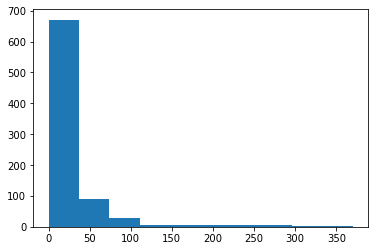

In [7]:
plt.hist(df_0['Итого'])

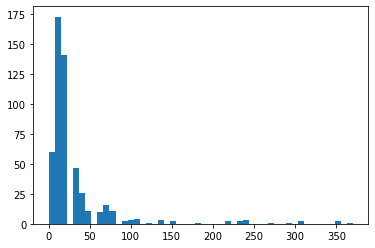

In [15]:
_ = plt.hist(df_0[df_0['year'] == '2020']['Итого'], bins=50)

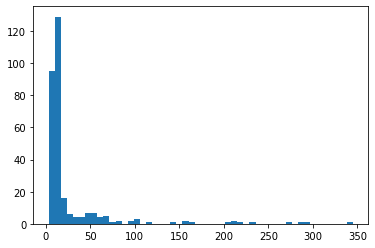

In [16]:
_ = plt.hist(df_0[df_0['year'] == '2021']['Итого'], bins=50)

In [3]:
df_0

,Наименование ДП,"-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-3, Заёмные средства (краткосрочные), RUB","-2, Заёмные средства (краткосрочные), RUB","-1, Заёмные средства (краткосрочные), RUB","-3, Кредиторская задолженность, RUB","-2, Кредиторская задолженность, RUB","-1, Кредиторская задолженность, RUB","-3, Краткосрочные обязательства, RUB","-2, Краткосрочные обязательства, RUB","-1, Краткосрочные обязательства, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,Факт. 1,Факт. 2,Факт. 3,Факт. 7,Факт. 12,Факт. 14,Факт. 15,Факт. 16,Факт. 20,Факт. 21,Факт. 23,Факт. 24,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 37,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 46,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-4, Основные средства , RUB","-4, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-4, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-4, Кредиторская задолженность, RUB","-4, Краткосрочные обязательства, RUB","-4, Выручка, RUB","-4, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB"
0,0,2.895541e+06,6.245860e+06,9.050955e+06,1.889724e+09,1.803724e+09,2.145239e+09,1.928685e+09,1.880842e+09,2.440078e+09,3.583766e+09,3.683359e+09,3.475461e+09,5.159380e+09,5.897326e+09,6.077448e+09,6.294000e+08,6.294000e+08,6.294000e+08,2.673020e+09,2.971017e+09,2.289274e+09,0.000000e+00,0.000000e+00,0.000000e+00,2.498777e+08,2.589732e+08,2.712210e+08,0.000000e+00,0.000000e+00,3.923917e+08,4.080056e+09,4.452922e+09,5.476906e+09,4.165168e+09,4.548178e+09,5.957031e+09,2.667698e+10,4.162693e+10,3.703952e+10,2.156814e+10,3.335443e+10,3.438313e+10,3.179697e+09,6.167667e+09,7.461828e+08,3.280355e+09,6.200120e+09,8.716191e+08,2019,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.000000e+00,3.885350e+04,3.439490e+04,1.448108e+08,1.487153e+08,1.526427e+08,1.456783e+08,1.497987e+08,1.538924e+08,5.584777e+07,4.678217e+07,1.563478e+08,1.489153e+08,1.898987e+08,2.914637e+08,1.345860e+06,1.345860e+06,1.345860e+06,2.726650e+08,2.774083e+08,3.106586e+08,0.000000e+00,0.000000e+00,0.000000e+00,3.108280e+06,4.528025e+06,5.033758e+06,9.745223e+06,4.760637e+07,6.349873e+07,9.075159e+06,1.015478e+07,6.616497e+07,1.882038e+07,5.776115e+07,1.296637e+08,2.554898e+08,2.573669e+08,5.434306e+08,2.056815e+08,2.055325e+08,4.169796e+08,1.212357e

In [4]:
len([x for x in df_0.columns.tolist() if x.startswith('Факт')])

36

In [4]:
q = "asd"

In [ ]:
q.startswith

In [4]:
df_0 = create_df_0years_known()

In [5]:
df_0.head(3)

,Наименование ДП,"-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-3, Заёмные средства (краткосрочные), RUB","-2, Заёмные средства (краткосрочные), RUB","-1, Заёмные средства (краткосрочные), RUB","-3, Кредиторская задолженность, RUB","-2, Кредиторская задолженность, RUB","-1, Кредиторская задолженность, RUB","-3, Краткосрочные обязательства, RUB","-2, Краткосрочные обязательства, RUB","-1, Краткосрочные обязательства, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,Факт. 1,Факт. 2,Факт. 3,Факт. 7,Факт. 12,Факт. 14,Факт. 15,Факт. 16,Факт. 20,Факт. 21,Факт. 23,Факт. 24,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 37,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 46,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-4, Основные средства , RUB","-4, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-4, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-4, Кредиторская задолженность, RUB","-4, Краткосрочные обязательства, RUB","-4, Выручка, RUB","-4, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB"
0,0,2.895541e+06,6.245860e+06,9.050955e+06,1.889724e+09,1.803724e+09,2.145239e+09,1.928685e+09,1.880842e+09,2.440078e+09,3.583766e+09,3.683359e+09,3.475461e+09,5.159380e+09,5.897326e+09,6.077448e+09,6.294000e+08,6.294000e+08,6.294000e+08,2.673020e+09,2.971017e+09,2.289274e+09,0.0,0.0,0.0,2.498777e+08,2.589732e+08,2.712210e+08,0.000000e+00,0.000000e+00,3.923917e+08,4.080056e+09,4.452922e+09,5.476906e+09,4.165168e+09,4.548178e+09,5.957031e+09,2.667698e+10,4.162693e+10,3.703952e+10,2.156814e+10,3.335443e+10,3.438313e+10,3.179697e+09,6.167667e+09,7.461828e+08,3.280355e+09,6.200120e+09,8.716191e+08,2019,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0.000000e+00,3.885350e+04,3.439490e+04,1.448108e+08,1.487153e+08,1.526427e+08,1.456783e+08,1.497987e+08,1.538924e+08,5.584777e+07,4.678217e+07,1.563478e+08,1.489153e+08,1.898987e+08,2.914637e+08,1.345860e+06,1.345860e+06,1.345860e+06,2.726650e+08,2.774083e+08,3.106586e+08,0.0,0.0,0.0,3.108280e+06,4.528025e+06,5.033758e+06,9.745223e+06,4.760637e+07,6.349873e+07,9.075159e+06,1.015478e+07,6.616497e+07,1.882038e+07,5.776115e+07,1.296637e+08,2.554898e+08,2.573669e+08,5.434306e+08,2.056815e+08,2.055325e+08,4.169796e+08,1.212357e+07,6.944586e+06,4.480064e+07,1.630064e+07,1.109172e+0

In [6]:
df_0['binary_target'].sum()

781

In [7]:
df_0.shape

(1387, 104)

In [9]:
ids_2021 = df_0[df_0['year'] == '2021']['Наименование ДП'].values

In [12]:
_df = df_0[df_0['year'] == '2020']
_df = _df[_df['Наименование ДП'].isin(ids_2021)]
_df['binary_target'].sum(), len(_df)

(247, 325)

In [13]:
_df = df_0[df_0['year'] == '2019']
_df = _df[_df['Наименование ДП'].isin(ids_2021)]
_df['binary_target'].sum(), len(_df)

(195, 325)

In [14]:
_df = df_0[df_0['year'] == '2021']
_df = _df[_df['Наименование ДП'].isin(ids_2021)]
_df['binary_target'].sum(), len(_df)

(111, 325)

In [4]:
qwe = pd.read_csv('../server2022/data/raw/agents2021.csv')

In [5]:
qwe[qwe['ПДЗ 1-30'] > 0]

['Unnamed: 0',
 'Наименование ДП',
 'Макс. ПДЗ за 2019 год, дней',
 'Сред. ПДЗ за 2019 год, дней',
 'Кол-во просрочек свыше 5-ти дней за 2019 год, шт.',
 'Общая сумма ПДЗ свыше 5-ти дней за 2019 год, руб.',
 'Кол-во раз ПДЗ за 2019 год, шт.',
 'Макс. ПДЗ за 2020 год, дней',
 'Сред. ПДЗ за 2020 год, дней',
 'Кол-во просрочек свыше 5-ти дней за 2020 год, шт.',
 'Общая сумма ПДЗ свыше 5-ти дней за 2020 год, руб.',
 'Кол-во раз ПДЗ за 2020 год, шт.',
 'Оценка потенциала контрагента 1, руб.',
 'Оценка потенциала контрагента 2, руб.',
 'Статус',
 '2016, Нематериальные активы, RUB',
 '2017, Нематериальные активы, RUB',
 '2018, Нематериальные активы, RUB',
 '2019, Нематериальные активы, RUB',
 '2020, Нематериальные активы, RUB',
 '2016, Основные средства , RUB',
 '2017, Основные средства , RUB',
 '2018, Основные средства , RUB',
 '2019, Основные средства , RUB',
 '2020, Основные средства , RUB',
 '2016, Внеоборотные активы, RUB',
 '2017, Внеоборотные активы, RUB',
 '2018, Внеоборотные активы, 

In [20]:
ids = set(qwe[qwe['ПДЗ 1-30'] > 0]['Наименование ДП'].values)

In [21]:
len(ids)

55

In [23]:
ids.update(set(qwe[qwe['ПДЗ 31-90'] > 0]['Наименование ДП'].values))
len(ids)

73

In [24]:
ids.update(set(qwe[qwe['ПДЗ 91-365'] > 0]['Наименование ДП'].values))
len(ids)

91

In [25]:
ids.update(set(qwe[qwe['ПДЗ более 365'] > 0]['Наименование ДП'].values))
len(ids)

111

In [8]:
(qwe['ПДЗ 31-90'] > 0).sum()

33

In [9]:
(qwe['ПДЗ 91-365'] > 0).sum()

45

In [10]:
(qwe['ПДЗ более 365'] > 0).sum()

54

325

In [2]:
df_1 = create_df_1year_known()

In [3]:
df_1

,Наименование ДП,Факт. 1,Факт. 2,Факт. 3,Факт. 4,Факт. 5,Факт. 6,Факт. 7,Факт. 8,Факт. 9,Факт. 10,Факт. 11,Факт. 12,Факт. 13,Факт. 14,Факт. 15,Факт. 16,Факт. 17,Факт. 18,Факт. 19,Факт. 20,Факт. 21,Факт. 22,Факт. 23,Факт. 24,Факт. 25,Факт. 26,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 34,Факт. 35,Факт. 36,Факт. 37,Факт. 38,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 43,Факт. 44,Факт. 45,Факт. 46,Факт. 47,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 52,Факт. 53,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-4, Основные средства , RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-4, Внеоборотные активы, RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-4, Уставный капитал , RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-3, Заёмные средства (краткосрочные), RUB",...,"-1, Выручка, RUB","-4, Себестоимость продаж, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,"Макс. ПДЗ за -1 год, дней","Сред. ПДЗ за -1 год, дней","Кол-во просрочек свыше 5-ти дней за -1 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.","Кол-во раз ПДЗ за -1 год, шт.","Оценка потенциала контрагента 1, руб.","Оценка потенциала контрагента 2, руб.",Статус,"-5, Нематериальные активы, RUB","-5, Основные средства , RUB","-5, Внеоборотные активы, RUB","-5, Дебиторская задолженность, RUB","-5, Оборотные активы, RUB","-5, Уставный капитал , RUB","-5, Капитал и резервы, RUB","-5, Заёмные средства (долгосрочные), RUB","-5, Долгосрочные обязательства, RUB","-5, Заёмные средства (краткосрочные), RUB","-5, Кредиторская задолженность, RUB","-5, Краткосрочные обязательства, RUB","-5, Выручка, RUB","-5, Себестоимость продаж, RUB","-5, Прибыль (убыток) до налогообложения , RUB","-5, Прибыль (убыток) от продажи, RUB",Факт. 1 (-1),Факт. 2 (-1),Факт. 3 (-1),Факт. 4 (-1),Факт. 5 (-1),Факт. 6 (-1),Факт. 7 (-1),Факт. 8 (-1),Факт. 9 (-1),Факт. 10 (-1),Факт. 11 (-1),Факт. 12 (-1),Факт. 13 (-1),Факт. 14 (-1),Факт. 15 (-1),Факт. 16 (-1),Факт. 17 (-1),Факт. 18 (-1),Факт. 19 (-1),Факт. 20 (-1),Факт. 21 (-1),Факт. 22 (-1),Факт. 23 (-1),Факт. 24 (-1),Факт. 25 (-1),Факт. 26 (-1),Факт. 27 (-1),Факт. 28 (-1),Факт. 29 (-1),Факт. 30 (-1),Факт. 31 (-1),Факт. 32 (-1),Факт. 33 (-1),Факт. 34 (-1),Факт. 35 (-1),Факт. 36 (-1),Факт. 37 (-1),Факт. 38 (-1),Факт. 39 (-1),Факт. 40 (-1),Факт. 41 (-1),Факт. 42 (-1),Факт. 43 (-1),Факт. 44 (-1),Факт. 45 (-1),Факт. 46 (-1),Факт. 47 (-1),Факт. 48 (-1),Факт. 49 (-1),Факт. 50 (-1),Факт. 51 (-1),Факт. 52 (-1),Факт. 53 (-1),Факт. 54 (-1),Факт. 55 (-1),Факт. 56 (-1),Факт. 57 (-1),Факт. 58 (-1),Факт. 59 (-1)

In [2]:
df_1 = create_df_1year_known()

In [3]:
df_1

,Наименование ДП,Факт. 1,Факт. 2,Факт. 3,Факт. 7,Факт. 12,Факт. 14,Факт. 15,Факт. 16,Факт. 20,Факт. 21,Факт. 23,Факт. 24,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 37,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 46,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-4, Основные средства , RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-4, Внеоборотные активы, RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-4, Уставный капитал , RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-3, Заёмные средства (краткосрочные), RUB","-2, Заёмные средства (краткосрочные), RUB","-1, Заёмные средства (краткосрочные), RUB","-4, Кредиторская задолженность, RUB","-3, Кредиторская задолженность, RUB","-2, Кредиторская задолженность, RUB","-1, Кредиторская задолженность, RUB","-4, Краткосрочные обязательства, RUB","-3, Краткосрочные обязательства, RUB","-2, Краткосрочные обязательства, RUB","-1, Краткосрочные обязательства, RUB","-4, Выручка, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB","-4, Себестоимость продаж, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,"Макс. ПДЗ за -1 год, дней","Сред. ПДЗ за -1 год, дней","Кол-во просрочек свыше 5-ти дней за -1 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.","Кол-во раз ПДЗ за -1 год, шт."
0,0,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,10,Х,Х,Н/Д,Х,Х,Х,Х,Х,Х,10.0,2.895541e+06,6.245860e+06,9.050955e+06,9.885987e+06,1.889724e+09,1.803724e+09,2.145239e+09,3.606103e+09,1.928685e+09,1.880842e+09,2.440078e+09,3.737611e+09,3.583766e+09,3.683359e+09,3.475461e+09,3.692142e+09,5.159380e+09,5.897326e+09,6.077448e+09,4.981792e+09,6.294000e+08,6.294000e+08,6.294000e+08,6.294000e+08,2.673020e+09,2.971017e+09,2.289274e+09,4.865035e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.498777e+08,2.589732e+08,2.712210e+08,2.764834e+08,0.000000e+00,0.000000e+00,3.923917e+08,0.000000e+00,4.080056e+09,4.452922e+09,5.476906e+09,3.478978e+09,4.165168e+09,4.548178e+09,5.957031e+09,3.577885e+09,2.667698e+10,4.162693e+10,3.703952e+10,3.234755e+10,2.156814e+10,3.335443e+10,3.438313e+10,2.673481e+10,3.179697e+09,6.167667e+09,7.461828e+08,3.603784e+09,3.280355e+09,6.200120e+09,8.716191e+08,3.658634e+09,2020,True,0,0.00,0,0.000000,0
1,1,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,Х,10,Х,Х,10,Х,Х,Х,Х,Х,Х,20.0,0.000000e+00,3.885350e+04,3.439490e+04,2.929936e+04,1.448108e+08,1.487153e+08,1.526427e+08,1.728459e+08,1.456783e+08,1.497987e+08,1.538924e+08,1.742637e+08,5.584777e+07,4.678217e+07,1.563478e+0

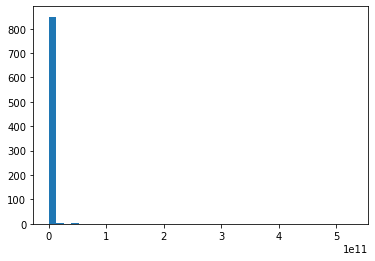

In [8]:
_ = plt.hist(df_1['-1, Уставный капитал , RUB'].values, bins=40)

In [13]:
(df_1['-1, Уставный капитал , RUB'].values < 100_000).sum()

447

In [14]:
(df_1['-1, Уставный капитал , RUB'].values < 1_000_000).sum()

532

In [15]:
(df_1['-1, Уставный капитал , RUB'].values < 10_000_000).sum()

639

In [16]:
df = df_1[df_1['year'] == '2021']

In [17]:
df.shape

(325, 109)

In [116]:
df = df.drop(columns=list(set(factors_2020) & set(df.columns.tolist())))

In [135]:
df_0[df_0['year'] == '2019']['binary_target'].sum()

307

In [136]:
df_0[df_0['year'] == '2020']['binary_target'].sum()

363

In [138]:
(df_0['year'] == '2020').sum()

531

In [129]:
df[['-4, Выручка, RUB', '-3, Выручка, RUB', '-2, Выручка, RUB', '-1, Выручка, RUB']].head(50).round()

,"-4, Выручка, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB"
531,4.162693e+10,3.703952e+10,3.234755e+10,2.794788e+10
532,2.699397e+09,2.592420e+09,2.754208e+09,2.583063e+09
533,6.658243e+10,8.611910e+10,9.409765e+10,9.629957e+10
534,3.361425e+10,4.637975e+10,5.253921e+10,6.249300e+10
535,5.978653e+10,7.500571e+10,6.581456e+10,6.628651e+10
536,4.274140e+08,3.970701e+08,3.311108e+08,2.675274e+08
537,0.000000e+00,1.031372e+09,1.157608e+09,1.415543e+09
538,3.790605e+08,3.392752e+08,2.804624e+08,1.424204e+08
539,5.996618e+08,6.946325e+08,6.374006e+08,5.319554e+08
540,1.714094e+09,1.705433e+09,2.284332e+09,2.004487e+09


In [19]:
df.head()

,Наименование ДП,Факт. 1,Факт. 2,Факт. 3,Факт. 7,Факт. 12,Факт. 14,Факт. 15,Факт. 16,Факт. 20,Факт. 21,Факт. 23,Факт. 24,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 37,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 46,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-4, Основные средства , RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-4, Внеоборотные активы, RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-4, Уставный капитал , RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-3, Заёмные средства (краткосрочные), RUB","-2, Заёмные средства (краткосрочные), RUB","-1, Заёмные средства (краткосрочные), RUB","-4, Кредиторская задолженность, RUB","-3, Кредиторская задолженность, RUB","-2, Кредиторская задолженность, RUB","-1, Кредиторская задолженность, RUB","-4, Краткосрочные обязательства, RUB","-3, Краткосрочные обязательства, RUB","-2, Краткосрочные обязательства, RUB","-1, Краткосрочные обязательства, RUB","-4, Выручка, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB","-4, Себестоимость продаж, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,"Макс. ПДЗ за -1 год, дней","Сред. ПДЗ за -1 год, дней","Кол-во просрочек свыше 5-ти дней за -1 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.","Кол-во раз ПДЗ за -1 год, шт."
531,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,6.245860e+06,9.050955e+06,9.885987e+06,2.332484e+06,1.803724e+09,2.145239e+09,3.606103e+09,4.292052e+09,1.880842e+09,2.440078e+09,3.737611e+09,4.379874e+09,3.683359e+09,3.475461e+09,3.692142e+09,4.977055e+09,5.897326e+09,6.077448e+09,4.981792e+09,6.170107e+09,6.294000e+08,6.294000e+08,6.294000e+08,6.294000e+08,2.971017e+09,2.289274e+09,4.865035e+09,6.881321e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.589732e+08,2.712210e+08,2.764834e+08,2.174739e+08,0.000000e+00,3.923917e+08,0.000000e+00,0.000000e+00,4.452922e+09,5.476906e+09,3.478978e+09,3.333520e+09,4.548178e+09,5.957031e+09,3.577885e+09,3.451186e+09,4.162693e+10,3.703952e+10,3.234755e+10,2.794788e+10,3.335443e+10,3.438313e+10,2.673481e+10,2.058317e+10,6.167667e+09,7.461828e+08,3.603784e+09,5.586341e+09,6.200120e+09,8.716191e+08,3.658634e+09,5.971943e+09,2021,True,10,6.400000,4,2.229696e+06,5
532,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,25.0,1.288025e+07,8.694904e+06,4.958599e+06,1.

In [42]:
nnans = {}
for c in df.columns.tolist():
    if not c.startswith('Факт. '):
        continue
    print(c, '   nans=', df[c].isna().sum(), '   diff=', len(df[c].unique()))
    nnans[c] = df[c].isna().sum()

Факт. 1    nans= 322    diff= 2
Факт. 2    nans= 321    diff= 2
Факт. 3    nans= 319    diff= 2
Факт. 7    nans= 322    diff= 2
Факт. 12    nans= 322    diff= 2
Факт. 14    nans= 321    diff= 2
Факт. 15    nans= 325    diff= 1
Факт. 16    nans= 325    diff= 1
Факт. 20    nans= 325    diff= 1
Факт. 21    nans= 325    diff= 1
Факт. 23    nans= 320    diff= 2
Факт. 24    nans= 323    diff= 2
Факт. 27    nans= 324    diff= 2
Факт. 28    nans= 323    diff= 2
Факт. 29    nans= 285    diff= 2
Факт. 30    nans= 321    diff= 2
Факт. 31    nans= 312    diff= 2
Факт. 32    nans= 323    diff= 2
Факт. 33    nans= 319    diff= 2
Факт. 37    nans= 323    diff= 2
Факт. 39    nans= 312    diff= 2
Факт. 40    nans= 324    diff= 2
Факт. 41    nans= 324    diff= 2
Факт. 42    nans= 323    diff= 2
Факт. 46    nans= 321    diff= 2
Факт. 48    nans= 323    diff= 2
Факт. 49    nans= 99    diff= 2
Факт. 50    nans= 320    diff= 2
Факт. 51    nans= 315    diff= 2
Факт. 54    nans= 179    diff= 2
Факт. 55    nan

In [43]:
len([x for x in nnans.values() if x <= 325])

36

In [47]:
len([x for x in nnans.values() if x <= 322])

21

In [37]:
len([x for x in nnans.values() if x <= 320])

14

In [109]:
len([x for x in nnans.values() if x <= 315])

9

In [38]:
len([x for x in nnans.values() if x <= 310])

5

In [48]:
len([x for x in nnans.values() if x <= 300])

5

In [49]:
len([x for x in nnans.values() if x <= 250])

4

In [50]:
len([x for x in nnans.values() if x <= 200])

2

In [105]:
df.columns.tolist()

['Наименование ДП',
 'Факт. 1',
 'Факт. 2',
 'Факт. 3',
 'Факт. 7',
 'Факт. 12',
 'Факт. 14',
 'Факт. 15',
 'Факт. 16',
 'Факт. 20',
 'Факт. 21',
 'Факт. 23',
 'Факт. 24',
 'Факт. 27',
 'Факт. 28',
 'Факт. 29',
 'Факт. 30',
 'Факт. 31',
 'Факт. 32',
 'Факт. 33',
 'Факт. 37',
 'Факт. 39',
 'Факт. 40',
 'Факт. 41',
 'Факт. 42',
 'Факт. 46',
 'Факт. 48',
 'Факт. 49',
 'Факт. 50',
 'Факт. 51',
 'Факт. 54',
 'Факт. 55',
 'Факт. 56',
 'Факт. 57',
 'Факт. 58',
 'Факт. 59',
 'Факт. 60',
 'Итого',
 '-4, Нематериальные активы, RUB',
 '-3, Нематериальные активы, RUB',
 '-2, Нематериальные активы, RUB',
 '-1, Нематериальные активы, RUB',
 '-4, Основные средства , RUB',
 '-3, Основные средства , RUB',
 '-2, Основные средства , RUB',
 '-1, Основные средства , RUB',
 '-4, Внеоборотные активы, RUB',
 '-3, Внеоборотные активы, RUB',
 '-2, Внеоборотные активы, RUB',
 '-1, Внеоборотные активы, RUB',
 '-4, Дебиторская задолженность, RUB',
 '-3, Дебиторская задолженность, RUB',
 '-2, Дебиторская задолженно

Макс. ПДЗ за -1 год, дней   :   0.6466910836069715
Сред. ПДЗ за -1 год, дней   :   0.6507325082091437
Кол-во просрочек свыше 5-ти дней за -1 год, шт.   :   0.6485434032163003
Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.   :   0.6520796497432011
Кол-во раз ПДЗ за -1 год, шт.   :   0.5522227835311947
Итого   :   0.6677612191630883


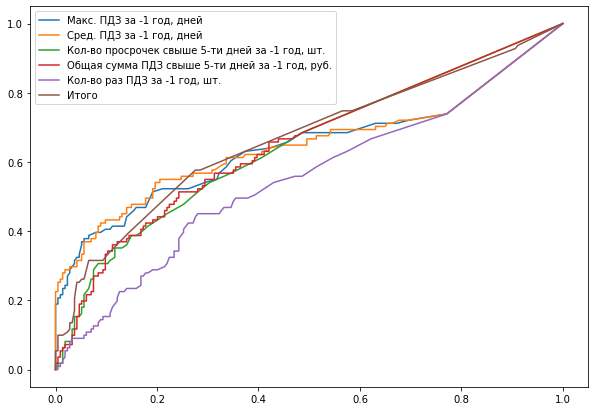

In [121]:
plt.figure(figsize=(10,7))
for f in df.columns.tolist()[-6:-1] + ['Итого',]:
    p = df[f].values
    p = [x if not np.isnan(x) else 0 for x in p]
    t = df['binary_target'].values

    tpr, fpr, trhs = roc_curve(t, p)
    print(f, '  :  ', roc_auc_score(t, p))

    plt.plot(tpr, fpr, label=f)    
    
plt.legend()

In [ ]:
['Основные средства', 
'Внеоборотные активы',
 'Дебиторская задолженность',
 'Оборотные активы',
 'Кредиторская задолженность',
 'Краткосрочные обязательства',
 
]

-4, Нематериальные активы, RUB   :   0.5877325924054896
-3, Нематериальные активы, RUB   :   0.6244211501220847
-2, Нематериальные активы, RUB   :   0.6200850383093374
-1, Нематериальные активы, RUB   :   0.6058769049423254
-4, Основные средства , RUB   :   0.6445651258735371
-3, Основные средства , RUB   :   0.7021133282815525
-2, Основные средства , RUB   :   0.6944725098930707
-1, Основные средства , RUB   :   0.6622463585080407
-4, Внеоборотные активы, RUB   :   0.6571945777553254
-3, Внеоборотные активы, RUB   :   0.7051022985602425
-2, Внеоборотные активы, RUB   :   0.6964090258482782
-1, Внеоборотные активы, RUB   :   0.664730150711459
-4, Дебиторская задолженность, RUB   :   0.6531531531531533
-3, Дебиторская задолженность, RUB   :   0.7120063989222867
-2, Дебиторская задолженность, RUB   :   0.7120905952681654
-1, Дебиторская задолженность, RUB   :   0.6889786983244928
-4, Оборотные активы, RUB   :   0.6433653279447671
-3, Оборотные активы, RUB   :   0.7044287277932137
-2, Обо

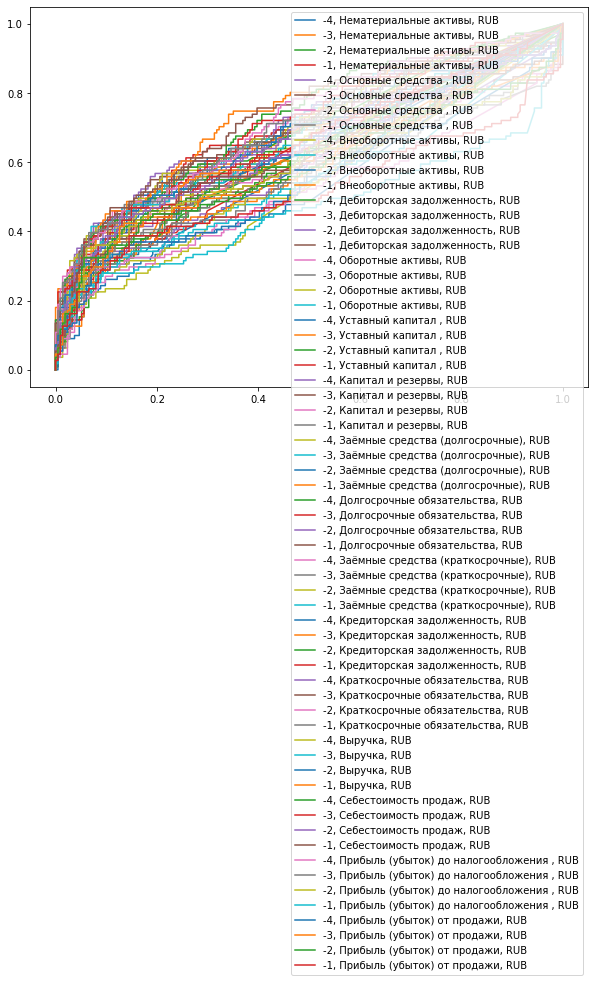

In [122]:
plt.figure(figsize=(10,7))
for f in df.columns.tolist():
    if not f.startswith('-'):
        continue
    p = df[f].values
    p = [x if not np.isnan(x) else 0 for x in p]
    t = df['binary_target'].values

    tpr, fpr, trhs = roc_curve(t, p)
    print(f, '  :  ', roc_auc_score(t, p))

    plt.plot(tpr, fpr, label=f)    
    
plt.legend()

In [123]:
df_0 = create_df_0years_known()

-4, Нематериальные активы, RUB   :   0.5877325924054896
-3, Нематериальные активы, RUB   :   0.6244211501220847
-2, Нематериальные активы, RUB   :   0.6200850383093374
-1, Нематериальные активы, RUB   :   0.6058769049423254
-4, Основные средства , RUB   :   0.6445651258735371
-3, Основные средства , RUB   :   0.7021133282815525
-2, Основные средства , RUB   :   0.6944725098930707
-1, Основные средства , RUB   :   0.6622463585080407
-4, Внеоборотные активы, RUB   :   0.6571945777553254
-3, Внеоборотные активы, RUB   :   0.7051022985602425
-2, Внеоборотные активы, RUB   :   0.6964090258482782
-1, Внеоборотные активы, RUB   :   0.664730150711459
-4, Дебиторская задолженность, RUB   :   0.6531531531531533
-3, Дебиторская задолженность, RUB   :   0.7120063989222867
-2, Дебиторская задолженность, RUB   :   0.7120905952681654
-1, Дебиторская задолженность, RUB   :   0.6889786983244928
-4, Оборотные активы, RUB   :   0.6433653279447671
-3, Оборотные активы, RUB   :   0.7044287277932137
-2, Обо

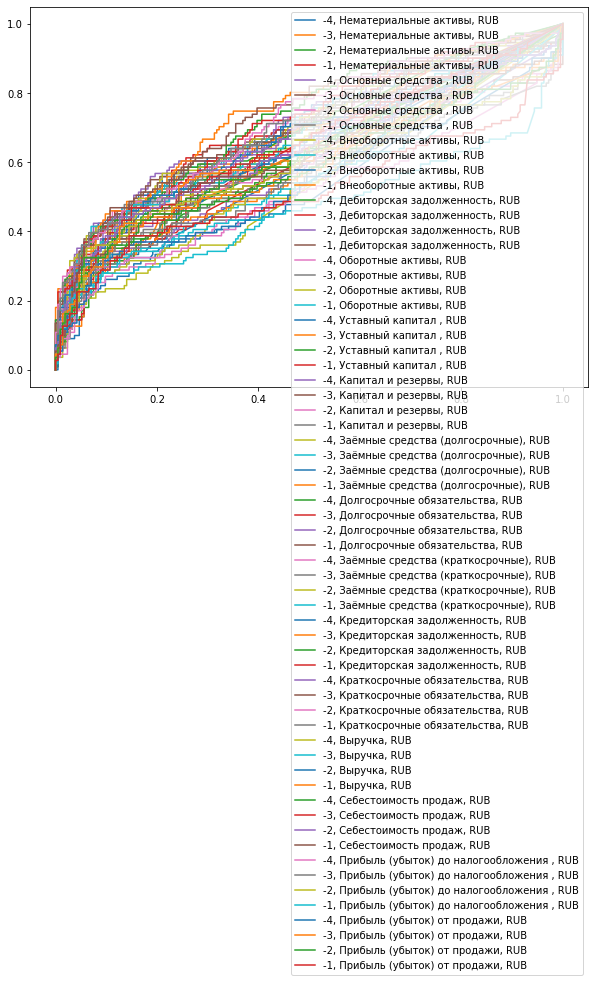

In [122]:
plt.figure(figsize=(10,7))
for f in df_0.columns.tolist():
    if not f.startswith('-'):
        continue
    p = df[f].values
    p = [x if not np.isnan(x) else 0 for x in p]
    t = df['binary_target'].values

    tpr, fpr, trhs = roc_curve(t, p)
    print(f, '  :  ', roc_auc_score(t, p))

    plt.plot(tpr, fpr, label=f)    
    
plt.legend()

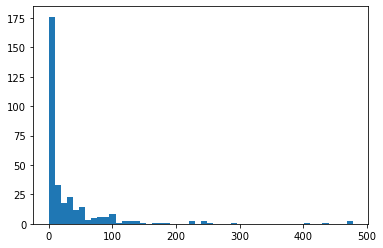

In [101]:
_ = plt.hist(df['Кол-во раз ПДЗ за -1 год, шт.'].values, bins=50)

(0.0, 100.0)

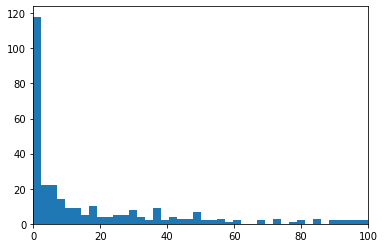

In [104]:
_ = plt.hist(df['Кол-во раз ПДЗ за -1 год, шт.'].values, bins=200)
plt.xlim([0, 100])

<AxesSubplot:xlabel='Кол-во просрочек свыше 5-ти дней за -1 год, шт.', ylabel='Кол-во раз ПДЗ за -1 год, шт.'>

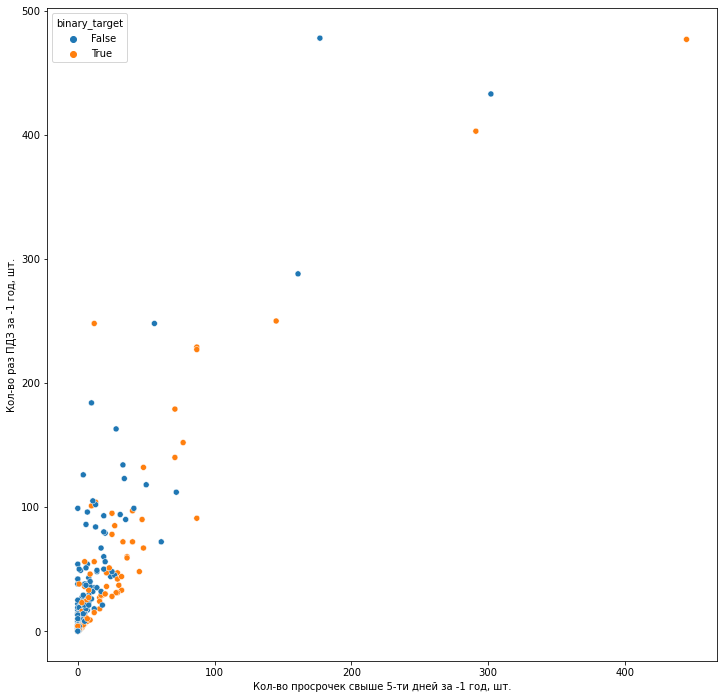

In [93]:
plt.figure(figsize=(12,12))
#plt.xlim([0, 10_000_000_000])
#df__ = df[df['-4, Выручка, RUB'] > 1]
#df__ = df__[df__['-1, Выручка, RUB'] > 1]
sns.scatterplot(x='Кол-во просрочек свыше 5-ти дней за -1 год, шт.', y='Кол-во раз ПДЗ за -1 год, шт.', data=df, hue='binary_target')

<AxesSubplot:xlabel='Кол-во просрочек свыше 5-ти дней за -1 год, шт.', ylabel='Кол-во раз ПДЗ за -1 год, шт.'>

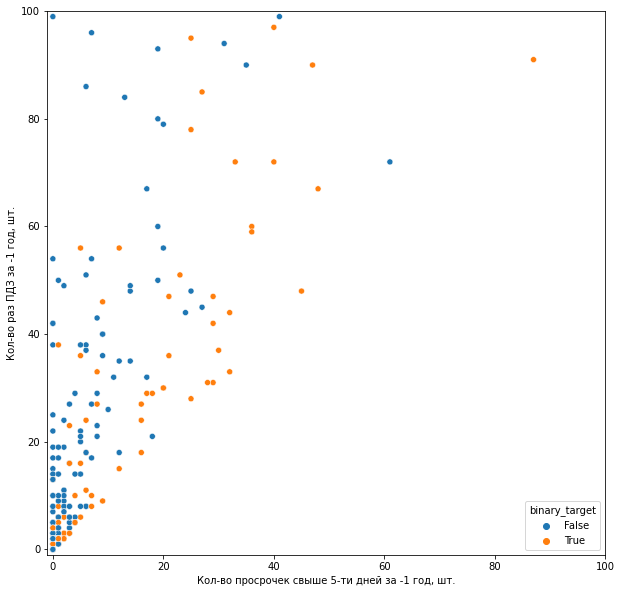

In [97]:
plt.figure(figsize=(10,10))
plt.xlim([-1, 100])
plt.ylim([-1, 100])
#df__ = df[df['-4, Выручка, RUB'] > 1]
#df__ = df__[df__['-1, Выручка, RUB'] > 1]
sns.scatterplot(x='Кол-во просрочек свыше 5-ти дней за -1 год, шт.', y='Кол-во раз ПДЗ за -1 год, шт.', data=df, hue='binary_target')

0.6485434032163003


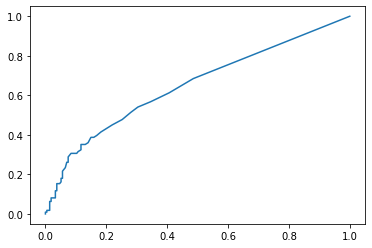

In [100]:
p = df['Кол-во просрочек свыше 5-ти дней за -1 год, шт.'].values
t = df['binary_target'].values

tpr, fpr, trhs = roc_curve(t, p)
print(roc_auc_score(t, p))

plt.plot(tpr, fpr)

In [70]:
df['delta income'] = (df['-1, Выручка, RUB'] - df['-4, Выручка, RUB']) / df['-1, Выручка, RUB']

/home/zakharov_a/new_miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [52]:
df

,Наименование ДП,Факт. 1,Факт. 2,Факт. 3,Факт. 7,Факт. 12,Факт. 14,Факт. 15,Факт. 16,Факт. 20,Факт. 21,Факт. 23,Факт. 24,Факт. 27,Факт. 28,Факт. 29,Факт. 30,Факт. 31,Факт. 32,Факт. 33,Факт. 37,Факт. 39,Факт. 40,Факт. 41,Факт. 42,Факт. 46,Факт. 48,Факт. 49,Факт. 50,Факт. 51,Факт. 54,Факт. 55,Факт. 56,Факт. 57,Факт. 58,Факт. 59,Факт. 60,Итого,"-4, Нематериальные активы, RUB","-3, Нематериальные активы, RUB","-2, Нематериальные активы, RUB","-1, Нематериальные активы, RUB","-4, Основные средства , RUB","-3, Основные средства , RUB","-2, Основные средства , RUB","-1, Основные средства , RUB","-4, Внеоборотные активы, RUB","-3, Внеоборотные активы, RUB","-2, Внеоборотные активы, RUB","-1, Внеоборотные активы, RUB","-4, Дебиторская задолженность, RUB","-3, Дебиторская задолженность, RUB","-2, Дебиторская задолженность, RUB","-1, Дебиторская задолженность, RUB","-4, Оборотные активы, RUB","-3, Оборотные активы, RUB","-2, Оборотные активы, RUB","-1, Оборотные активы, RUB","-4, Уставный капитал , RUB","-3, Уставный капитал , RUB","-2, Уставный капитал , RUB","-1, Уставный капитал , RUB","-4, Капитал и резервы, RUB","-3, Капитал и резервы, RUB","-2, Капитал и резервы, RUB","-1, Капитал и резервы, RUB","-4, Заёмные средства (долгосрочные), RUB","-3, Заёмные средства (долгосрочные), RUB","-2, Заёмные средства (долгосрочные), RUB","-1, Заёмные средства (долгосрочные), RUB","-4, Долгосрочные обязательства, RUB","-3, Долгосрочные обязательства, RUB","-2, Долгосрочные обязательства, RUB","-1, Долгосрочные обязательства, RUB","-4, Заёмные средства (краткосрочные), RUB","-3, Заёмные средства (краткосрочные), RUB","-2, Заёмные средства (краткосрочные), RUB","-1, Заёмные средства (краткосрочные), RUB","-4, Кредиторская задолженность, RUB","-3, Кредиторская задолженность, RUB","-2, Кредиторская задолженность, RUB","-1, Кредиторская задолженность, RUB","-4, Краткосрочные обязательства, RUB","-3, Краткосрочные обязательства, RUB","-2, Краткосрочные обязательства, RUB","-1, Краткосрочные обязательства, RUB","-4, Выручка, RUB","-3, Выручка, RUB","-2, Выручка, RUB","-1, Выручка, RUB","-4, Себестоимость продаж, RUB","-3, Себестоимость продаж, RUB","-2, Себестоимость продаж, RUB","-1, Себестоимость продаж, RUB","-4, Прибыль (убыток) до налогообложения , RUB","-3, Прибыль (убыток) до налогообложения , RUB","-2, Прибыль (убыток) до налогообложения , RUB","-1, Прибыль (убыток) до налогообложения , RUB","-4, Прибыль (убыток) от продажи, RUB","-3, Прибыль (убыток) от продажи, RUB","-2, Прибыль (убыток) от продажи, RUB","-1, Прибыль (убыток) от продажи, RUB",year,binary_target,"Макс. ПДЗ за -1 год, дней","Сред. ПДЗ за -1 год, дней","Кол-во просрочек свыше 5-ти дней за -1 год, шт.","Общая сумма ПДЗ свыше 5-ти дней за -1 год, руб.","Кол-во раз ПДЗ за -1 год, шт.",delta income
531,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,6.245860e+06,9.050955e+06,9.885987e+06,2.332484e+06,1.803724e+09,2.145239e+09,3.606103e+09,4.292052e+09,1.880842e+09,2.440078e+09,3.737611e+09,4.379874e+09,3.683359e+09,3.475461e+09,3.692142e+09,4.977055e+09,5.897326e+09,6.077448e+09,4.981792e+09,6.170107e+09,6.294000e+08,6.294000e+08,6.294000e+08,6.294000e+08,2.971017e+09,2.289274e+09,4.865035e+09,6.881321e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.589732e+08,2.712210e+08,2.764834e+08,2.174739e+08,0.000000e+00,3.923917e+08,0.000000e+00,0.000000e+00,4.452922e+09,5.476906e+09,3.478978e+09,3.333520e+09,4.548178e+09,5.957031e+09,3.577885e+09,3.451186e+09,4.162693e+10,3.703952e+10,3.234755e+10,2.794788e+10,3.335443e+10,3.438313e+10,2.673481e+10,2.058317e+10,6.167667e+09,7.461828e+08,3.603784e+09,5.586341e+09,6.200120e+09,8.716191e+08,3.658634e+09,5.971943e+09,2021,True,10,6.400000,4,2.229696e+06,5,0.328611
532,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,25.0,1.288025e+07,8.6949

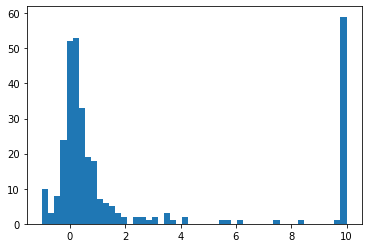

In [69]:
_ = plt.hist(np.clip(df['delta income'].values, -5, 10), bins=50)

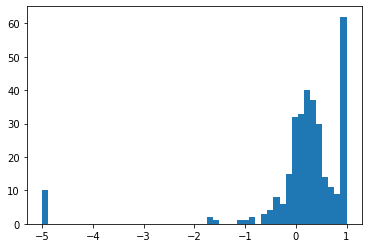

In [71]:
_ = plt.hist(np.clip(df['delta income'].values, -5, 10), bins=50)

In [84]:
(df__['-1, Выручка, RUB'] < 1).sum()

0

<AxesSubplot:xlabel='-4, Выручка, RUB', ylabel='delta income'>

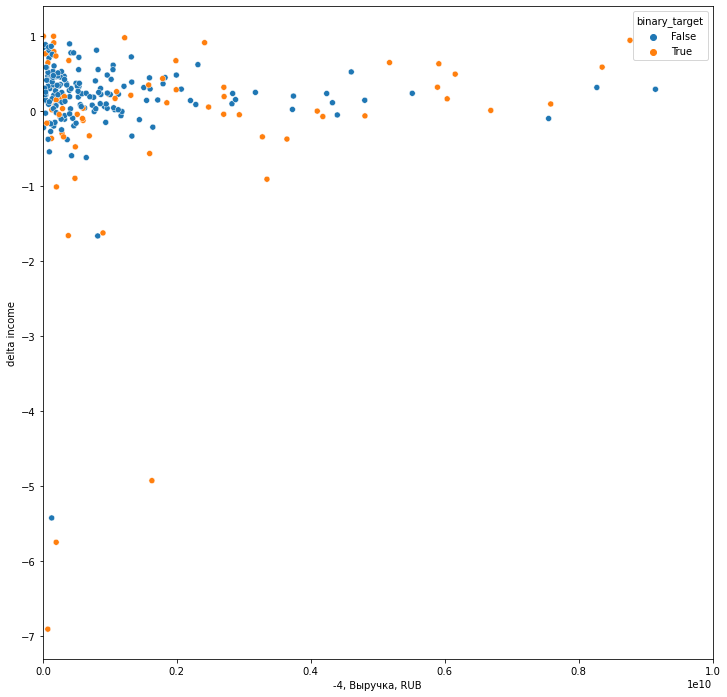

In [92]:
plt.figure(figsize=(12,12))
plt.xlim([0, 10_000_000_000])
df__ = df[df['-4, Выручка, RUB'] > 1]
df__ = df__[df__['-1, Выручка, RUB'] > 1]
sns.scatterplot(x='-4, Выручка, RUB', y='delta income', data=df__, hue='binary_target')